# BII project land use and intensity
This notebook contains the code for pre-processing the variables in to the required format and the subsequent extraction of the data.

1. Step 1: A 1km and 8km grid is defined.
2. Step 2: Each variable is imported, filtered and scaled. If area is required, converted to area per catgeory per 1x1 km cell. If mean variable is required, the mean value per variable per 1x1 km block is obtained.
3. Step 3: GEEML is used to extract the 1x1km data for each 1x1km grid cell.
4. Step 4: The Expert decision tree is applied for each 1x1km cell in python.
5. Step 5: The intensity scores are derived by first noralising all variables and thereafter, weighting them equally (1/#vars)

In [1]:
# define 1km grid
import ee
# ee.Authenticate()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
import geemap
from tqdm.auto import tqdm
from geeml.utils import createGrid, getCountry, eeprint
from geeml.extract import extractor

In [2]:
poi = ee.Geometry.Point([24.934,-28.679])
SA = getCountry(poi)
aoi =  SA

grid1km, _ = createGrid(1000, aoi)
grid1kmr, _ = createGrid(1000, aoi, vect= False)
# Create a 8km raster with unique id
grid8km, _ = createGrid(8000, aoi, vect = False)

In [3]:
# Urban cover (10m>250m>1km) 2019
area = ee.Image.pixelArea().divide(1e6).clip(aoi.geometry().buffer(5000))
urban_cover = ee.ImageCollection("projects/sat-io/open-datasets/WSF/WSF_2019").filterBounds(aoi)\
.mosaic().eq(255).unmask(0)
urbanAreaImage = area.multiply(urban_cover).rename('areakm2_urban')

# Highly irrigated areas (9276km) 2019
irrigated = ee.Image("users/deepakna/global_irrigation_maps/2015").selfMask().rename('irrigation')
irrigatedMed = area.multiply(irrigated.eq(1).unmask(0)).rename('areakm2_irrigatedMed')
irrigatedHigh = area.multiply(irrigated.eq(2).unmask(0)).rename('areakm2_irrigatedHigh')

# Crop cover (30 m)
crop_cover = ee.ImageCollection("users/potapovpeter/Global_cropland_2019").filterBounds(aoi).mosaic()
cropAreaImage = area.multiply(crop_cover).rename('areakm2_cropCover')

# Protected area
prot_areas = ee.FeatureCollection("projects/ee-geethensingh/assets/WDPA_Africa_strict").filterBounds(aoi)
protectedAreaImage = area.clipToCollection(prot_areas).unmask(0).rename('areakm2_protArea')    

# Plantation and tree crop
result = ee.ImageCollection("users/liuzhujun/SDPT_NEW").mosaic()
plantag = ee.Image("users/duzhenrong/SDPT/sdpt_plantag")
china_plantyear = ee.ImageCollection("users/liuzhujun/SDPT_China").mosaic().rename('plantyear')
DescalesOP = ee.ImageCollection("users/liuzhujun/Descales").mosaic()
op = DescalesOP.updateMask(DescalesOP.gt(1980)).rename('plantyear')
sdpt_name = ee.Image("users/duzhenrong/SDPT/sdpt_name")

china_plantyear=china_plantyear.updateMask(china_plantyear.gt(1980))
result=result.rename('plantyear').updateMask((sdpt_name.lt(120).And(sdpt_name.gt(0))).Or(sdpt_name.gt(129))).toInt32()

plantationForest=ee.ImageCollection([result.updateMask(plantag.eq(1)),china_plantyear]).mosaic().gt(0).unmask(0) 
plantationAreaImage = area.updateMask(plantationForest).rename('areakm2_plantation')
treeCrop=result.multiply(plantag.eq(2))
treeCrop =ee.ImageCollection([treeCrop,op]).mosaic().gt(0)  
treeCropAreaImage = area.multiply(treeCrop).rename('areakm2_treeCrop')

#Soil nutrients
Soil_Lownutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'Low'))
Soil_Mednutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'Medium'))
Soil_Highnutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'High'))

soilLowNutrientAreaImage = area.clipToCollection(Soil_Lownutrient).unmask(0).rename('areakm2_slowNutrArea')
soilMedNutrientAreaImage = area.clipToCollection(Soil_Mednutrient).unmask(0).rename('areakm2_sMedNutriArea')
soilHighNutrientAreaImage = area.clipToCollection(Soil_Highnutrient).unmask(0).rename('areakm2_sHighNutriArea')

# Population Density
popDensity = ee.ImageCollection("CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density")\
.select('unwpp-adjusted_population_density').filterBounds(aoi).mosaic().rename('popDensity').unmask(0)
                                       
# Grazing Intensity
cattleDensity = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Ct_2010_Da').rename('cattleDensity').unmask(0)
sheepDensity = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Sh_2010_Da').rename('sheepDensity').unmask(0)
goatDensity = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Gt_2010_Da').rename('goatDensity').unmask(0)

# Sand Content
sandContent = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/sand_content").select('b1')\
.rename('perc_sandContent')

# Precipitation
years = list(range(1991,2021))
precipitation = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterBounds(aoi)  
precipitation = ee.Image(ee.ImageCollection(ee.List(years).map(lambda year: precipitation\
.filterDate(ee.Number(year).format(), ee.Number(year).add(1).format()).sum())).mean().rename('mm_precipitation')).unmask(0)  

In [4]:
# Nitrogen input
proj = ee.Projection('EPSG:4326').scale(0.25,0.25)
grid = aoi.geometry().coveringGrid(proj)

nInput = ee.FeatureCollection("projects/ee-geethensingh/assets/Nfur_15arcmins").filterBounds(aoi)\
.map(lambda x: x.set("Nfer_type",ee.Algorithms.ObjectType(x.get("Nfer_kgha_"))))
nInputStr = nInput.filter(ee.Filter.eq('Nfer_type', 'String')).map(lambda x: x.set("Nfer_kgha_",ee.Number.parse(x.get("Nfer_kgha_")).toFloat()))
nInputNumber = nInput.filter(ee.Filter.neq('Nfer_type', 'String')).map(lambda x: x.set("Nfer_kgha_",ee.Number(x.get("Nfer_kgha_")).toFloat()))

nInput = nInputStr.merge(nInputNumber)

def pointToGrid(ft):
    feat = ee.Feature(ft);
    first = nInput.filterBounds(feat.geometry()).aggregate_first('Nfer_kgha_');
    return feat.set('Nfer_kgha_', first);

nInput = grid.filterBounds(nInput).map(pointToGrid)\
.reduceToImage(**{'properties': ee.List(["Nfer_kgha_"]), 'reducer': ee.Reducer.first()})\
.rename('Nfer_kgha')

In [4]:
dd = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs"

sumCovariates = urbanAreaImage.addBands([irrigatedMed, irrigatedHigh, cropAreaImage,\
                                        protectedAreaImage, soilLowNutrientAreaImage,\
                                        soilMedNutrientAreaImage, soilHighNutrientAreaImage,\
                                        plantationAreaImage, treeCropAreaImage, popDensity,\
                                        sheepDensity, goatDensity,cattleDensity])

extractor(sumCovariates, aoi.geometry(), scale = 1000, dd = dd, target = grid1km, crs = 'EPSG:4326', num_threads = 25)\
.extractByGrid(reduce = True, reducer = ee.Reducer.sum(), gridSize = 100000, batchSize = 2500, filename = 'sum3_1km.csv')

sum3_1km.csv: |                                                                        | [  0.0%] in 00:00 (et…

In [46]:
fieldSize = ee.FeatureCollection("projects/ee-geethensingh/assets/dominant_field_sizes").filterBounds(aoi)\
.filter(ee.Filter.neq('field_size', 'NA')).map(lambda x: x.set("field_size_",ee.Number.parse(x.get("field_size"))))

def maxSize(ft):
    feat = ee.Feature(ft);
    max_ = fieldSize.filterBounds(feat.geometry()).aggregate_max('field_size_');
    return feat.set('max_fieldSize', max_);

fieldSize = grid1km.filterBounds(fieldSize).map(maxSize).reduceToImage(**{
  'properties': ['max_fieldSize'],
  'reducer': ee.Reducer.first()
}).rename('fieldSize');

fieldSize = ee.Image.pixelCoordinates('EPSG:4326').addBands([fieldSize, grid1kmr.rename('id1km'), grid8km.rename('id8km')])

dd = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs"
extractor(fieldSize, aoi.geometry(), scale = 1000, dd = dd, target = grid1kmr, crs = 'EPSG:4326', num_threads = 25)\
.extractPoints(gridSize = 100000, batchSize = 2500, filename = 'fieldSize_1km.csv')

fieldSize_1km.csv: |                                                                   | [  0.0%] in 00:00 (et…

In [67]:
fieldSize = ee.FeatureCollection("projects/ee-geethensingh/assets/dominant_field_sizes").filterBounds(aoi)\
.filter(ee.Filter.neq('field_size', 'NA')).map(lambda x: x.set("field_size_",ee.Number.parse(x.get("field_size"))))

def maxSize(ft):
    feat = ee.Feature(ft);
    max_ = fieldSize.filterBounds(feat.geometry()).aggregate_max('field_size_');
    return feat.set('max_fieldSize', max_);

fieldSize = grid1km.filterBounds(fieldSize).map(maxSize).reduceToImage(**{
  'properties': ['max_fieldSize'],
  'reducer': ee.Reducer.first()
}).rename('fieldSize');

fieldSize = ee.Image.pixelCoordinates('EPSG:4326').addBands([fieldSize, grid1kmr.rename('id1km'), grid8km.rename('id8km')])

dd = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs"
extractor(fieldSize, aoi.geometry(), scale = 1000, dd = dd, target = grid1km, crs = 'EPSG:4326', num_threads = 25)\
.extractByGrid(reduce = True, reducer = ee.Reducer.first(), gridSize = 100000, batchSize = 2500, filename = 'fieldSize2_1km.csv')

fieldSize2_1km.csv: |                                                                  | [  0.0%] in 00:00 (et…

In [6]:
dd = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs"

precipitation = ee.Image('projects/ee-geethensingh/assets/Hayley/SA_mean_precip')
sandContent = ee.Image('projects/ee-geethensingh/assets/Hayley/SA_mean_sandContent')
meanCovariates = precipitation.addBands([sandContent, nInput])

extractor(meanCovariates, aoi.geometry(), scale = 1000, dd = dd, target = grid1km, crs = 'EPSG:4326', num_threads = 25)\
.extractByGrid(reduce = True, reducer = ee.Reducer.mean(), gridSize = 100000, batchSize = 2500, filename = 'mean2_1km.csv')

mean2_1km.csv: |                                                                       | [  0.0%] in 00:00 (et…

In [47]:
dd = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs"

firstCovariates = grid8km.rename('id8km').addBands([grid1kmr.rename('id1km')])

extractor(firstCovariates, aoi.geometry(), scale = 1000, dd = dd, target = grid1km, crs = 'EPSG:4326', num_threads = 25)\
.extractByGrid(reduce = True, reducer = ee.Reducer.median(), gridSize = 100000, batchSize = 2500, filename = 'median_1km.csv')

median_1km.csv: |                                                                      | [  0.0%] in 00:00 (et…

## Prepare data

In [191]:
# For grid cells with crop_cover and no data, assign field size of nearest cell.
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

os.chdir(r"C:\Users\coach\myfiles\miscellenous\hayley\outputs")
print(os.getcwd())

# #Field Size data
df = pd.read_csv(r"fieldSize2_1km.csv", low_memory=False, header = None, index_col = False, skiprows=1)
df.columns = ['x', 'y', 'fieldSize', 'id1km', 'id8km', 'gid']

C:\Users\coach\myfiles\miscellenous\hayley\outputs


In [192]:
df1 = pd.read_csv(r"sum3_1km.csv", low_memory=False, header = None, index_col = False, skiprows=1)
df1.columns = ['areakm2_urban', 'areakm2_irrigatedMed',
       'areakm2_irrigatedHigh', 'areakm2_cropCover', 'areakm2_protArea',
       'areakm2_slowNutrArea', 'areakm2_sMedNutriArea',
       'areakm2_sHighNutriArea', 'areakm2_plantation', 'areakm2_treeCrop',
       'popDensity', 'sheepDensity', 'goatDensity', 'cattleDensity', 'gid']

In [193]:
# Mean covaraite data
dfmean = pd.read_csv(r"mean2_1km.csv", low_memory=False, header = None, index_col = False, skiprows=1)
dfmean.columns = ['mean_precip' ,'mean_sandContent', 'Nfer_kgha', 'gid']

In [194]:
dfJoin = pd.merge(df1, dfmean, on= 'gid')
dfAll = pd.merge(dfJoin, df, on= 'gid').drop_duplicates().reset_index(drop=True)

In [214]:
dfs1 = dfAll.loc[dfAll['areakm2_cropCover']>0, ['x', 'y', 'fieldSize', 'gid']]
dfs2 = dfs1.dropna()[['x', 'y', 'fieldSize']]
dfs3 = dfs1[['x', 'y', 'gid']]

In [215]:
gdf2 = gpd.GeoDataFrame(dfs2.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(dfs2.x, dfs2.y))
gdf3 = gpd.GeoDataFrame(dfs3.drop(['x', 'y'],axis=1), geometry = gpd.points_from_xy(dfs3.x, dfs3.y))

In [216]:
import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

joinNearest = ckdnearest(gdf3, gdf2)

In [223]:
result = pd.DataFrame(joinNearest)[['gid', 'fieldSize']]
result.columns = ['gid', 'fieldSize2']

In [232]:
dfAll.shape
print(result.shape)

(131189, 2)


In [298]:
finaldf = pd.merge(dfAll, result, how= 'outer',on = 'gid').drop_duplicates()
finaldf['fieldSize2'] = finaldf['fieldSize2'].fillna(0)
finaldf['fieldSize'] = finaldf['fieldSize2'].astype('int')

dfF = finaldf.drop('fieldSize2', axis=1).reset_index(drop=True)
dfF.loc[392282,'areakm2_treeCrop'] = 0
dfF.loc[:,'id8km'] = dfF.loc[:,'id8km'].fillna(0)
dfF.loc[:,'id1km'] = dfF.loc[:,'id1km'].fillna(0)
dfF = dfF[dfF['areakm2_treeCrop']!= '2726,-3471']
dfF.loc[:,'areakm2_treeCrop'] = dfF.loc[:,'areakm2_treeCrop'].astype('float64')
dfF.loc[:,'gid'] = dfF.loc[:,'gid'].astype('string')
dfF.loc[:,'id8km'] = dfF.loc[:,'id8km'].astype('int64')
dfF.loc[:,'Nfer_kgha'] = dfF.loc[:,'Nfer_kgha'].astype('float64')
dfF.reset_index(drop=True).to_feather('SA_POC_03112022.feather')

C:\Users\coach\AppData\Local\Temp\ipykernel_15432\3180726161.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfF.loc[:,'areakm2_treeCrop'] = dfF.loc[:,'areakm2_treeCrop'].astype('float64')
C:\Users\coach\AppData\Local\Temp\ipykernel_15432\3180726161.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfF.loc[:,'gid'] = dfF.loc[:,'gid'].astype('string')
C:\Users\coach\AppData\Local\Temp\ipykernel_15432\3180726161.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting 

C:\WINDOWS\System32\erty\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


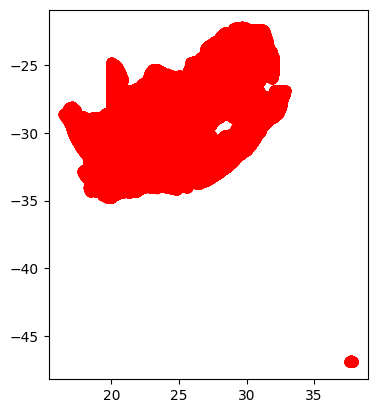

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to South Africa.
ax = world[world.continent == 'South Africa'].plot(
    color='white', edgecolor='black')

# plot ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

## Decision tree

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd

filename = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs\SA_POC_03112022.feather"
df = pd.read_feather(filename)

In [2]:
scaler = MinMaxScaler()
colnames = list(df.drop(['gid', 'x', 'y', 'fieldSize', 'id1km', 'id8km'],axis=1))
print(colnames)
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(['gid', 'x', 'y', 'fieldSize', 'id1km', 'id8km'],axis=1)),columns = colnames)
# df_scaled.columns = colnames
df2 = pd.concat([df, df_scaled.add_prefix('scaled_')], axis=1)
df2

['areakm2_urban', 'areakm2_irrigatedMed', 'areakm2_irrigatedHigh', 'areakm2_cropCover', 'areakm2_protArea', 'areakm2_slowNutrArea', 'areakm2_sMedNutriArea', 'areakm2_sHighNutriArea', 'areakm2_plantation', 'areakm2_treeCrop', 'popDensity', 'sheepDensity', 'goatDensity', 'cattleDensity', 'mean_precip', 'mean_sandContent', 'Nfer_kgha']


,areakm2_urban,areakm2_irrigatedMed,areakm2_irrigatedHigh,areakm2_cropCover,areakm2_protArea,areakm2_slowNutrArea,areakm2_sMedNutriArea,areakm2_sHighNutriArea,areakm2_plantation,areakm2_treeCrop,...,scaled_areakm2_sHighNutriArea,scaled_areakm2_plantation,scaled_areakm2_treeCrop,scaled_popDensity,scaled_sheepDensity,scaled_goatDensity,scaled_cattleDensity,scaled_mean_precip,scaled_mean_sandContent,scaled_Nfer_kgha
0,0.000000,0.0,0,0.000000,0.187803,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000121,0.106703,0.128683,0.195052,0.382256,0.644739,NaN
1,0.000000,0.0,0,0.000000,0.676740,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000121,0.106703,0.128683,0.195052,0.382256,0.677911,NaN
2,0.000000,0.0,0,0.000000,0.556934,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000121,0.106703,0.128683,0.195052,0.366147,0.642009,NaN
3,0.000000,0.0,0,0.825688,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000099,0.106703,0.128683,0.195052,0.350039,0.718940,NaN
4,0.003238,0.0,0,0.825688,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000098,0.106703,0.128683,0.195052,0.350039,0.730394,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406816,0.000000,0.0,0,0.000000,0.000000,0.0,0.919741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000019,0.015653,0.085360,0.081163,0.178120,0.882570,0.063361
1406817,0.000000,0.0,0,0.000000,0.000000,0.0,0.919741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000019,0.015653,0.085360,0.081163,0.175626,0.884133,0.063361
1406818,0.003607,0.0,0,0.000000,0.000000,0.0,0.919741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000019,0.015653,0.085360,0.081163,0.175626,0.883045,0.063361
1406819,0.010820,0.0,0,0.000000,0.000000,0.0,0.919741,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000019,0.015653,0.085360,0.081163,0.175626,0.880486,0.063361


In [3]:
#1= Urban
#2= Non agricultural settlements
#3= Agricultural settlements
#4= Timber plantations
#5= Tree Croplands
#6= CropLands
#7= Protected areas
#8= Rangelands/Near-natural lands

def ExpertDT(df):

    #8= Rangelands/Near-natural lands
    df['Land_Use'] = 8

    #7= Protected areas
    df.loc[df['areakm2_protArea']>0.5, 'Land_Use'] = 7

    #6= CropLands
    df.loc[df['areakm2_cropCover']>0.2, 'Land_Use'] = 6

    #5= Tree Croplands
    df.loc[df['areakm2_treeCrop']>0.2, 'Land_Use'] = 5

    #4= Timber plantations
    df.loc[df['areakm2_plantation']>0.2, 'Land_Use'] = 4

    #3= Agricultural settlements
    df.loc[(df['popDensity']>100)&\
       (df['areakm2_cropCover']>=0.05) & (df['areakm2_cropCover']<=0.2) &\
       (df['areakm2_treeCrop']>=0.05) & (df['areakm2_treeCrop']<=0.2) &\
       (df['areakm2_plantation']>=0.05) & (df['areakm2_plantation']<=0.2) &\
       (df['scaled_cattleDensity']>= 0.2), 'Land_Use'] = 3

    #2= Non agricultural settlements
    df.loc[(df['popDensity']>100)&\
       (df['areakm2_cropCover']<0.05) &\
       (df['areakm2_treeCrop']<0.05) &\
       (df['areakm2_plantation']<0.05)&\
       (df['scaled_cattleDensity']>= 0.2), 'Land_Use'] = 2
    #1= Urban
    df.loc[(df['areakm2_urban']>0.2)&
        (df['popDensity']>1500) , 'Land_Use'] = 1
    return df
    
result = ExpertDT(df2)

In [4]:
result['Land_Use'].value_counts()

8    1103954
6     126502
7      86715
2      40107
4      34222
5       7800
1       7521
Name: Land_Use, dtype: int64

<AxesSubplot: ylabel='Frequency'>

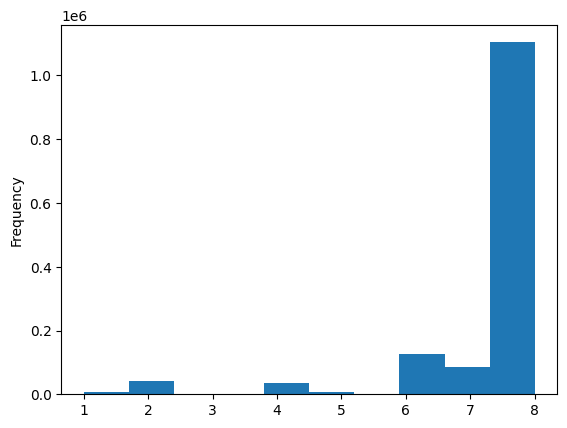

In [7]:
result['Land_Use'].plot.hist()

In [5]:
result.columns

Index(['areakm2_urban', 'areakm2_irrigatedMed', 'areakm2_irrigatedHigh',
       'areakm2_cropCover', 'areakm2_protArea', 'areakm2_slowNutrArea',
       'areakm2_sMedNutriArea', 'areakm2_sHighNutriArea', 'areakm2_plantation',
       'areakm2_treeCrop', 'popDensity', 'sheepDensity', 'goatDensity',
       'cattleDensity', 'gid', 'mean_precip', 'mean_sandContent', 'Nfer_kgha',
       'x', 'y', 'fieldSize', 'id1km', 'id8km', 'scaled_areakm2_urban',
       'scaled_areakm2_irrigatedMed', 'scaled_areakm2_irrigatedHigh',
       'scaled_areakm2_cropCover', 'scaled_areakm2_protArea',
       'scaled_areakm2_slowNutrArea', 'scaled_areakm2_sMedNutriArea',
       'scaled_areakm2_sHighNutriArea', 'scaled_areakm2_plantation',
       'scaled_areakm2_treeCrop', 'scaled_popDensity', 'scaled_sheepDensity',
       'scaled_goatDensity', 'scaled_cattleDensity', 'scaled_mean_precip',
       'scaled_mean_sandContent', 'scaled_Nfer_kgha', 'Land_Use'],
      dtype='object')

## Intensity

In [10]:
result['intensity'] = -1

#1= Urban
result.loc[(result['Land_Use']==1), 'intensity'] = (result['scaled_areakm2_urban']+result['scaled_popDensity'])/2

#2= Non agricultural settlements
result.loc[(result['Land_Use']==2), 'intensity'] = (result['scaled_cattleDensity']+\
                                                    result['scaled_popDensity']+\
                                                    result['scaled_areakm2_cropCover']+\
                                                    result['scaled_areakm2_treeCrop']+\
                                                    result['scaled_areakm2_plantation']\
                                                   )/5

#3= Agricultural settlements
result.loc[(result['Land_Use']==3), 'intensity'] = (result['scaled_cattleDensity']+\
                                                    (1-result['scaled_popDensity'])+\
                                                    result['scaled_areakm2_cropCover']+\
                                                    result['scaled_areakm2_treeCrop']+\
                                                    result['scaled_areakm2_plantation']\
                                                   )/5

#5= Tree Croplands
result.loc[(result['Land_Use']==5), 'intensity'] = (result['scaled_areakm2_treeCrop']+\
                                                    result['scaled_Nfer_kgha']\
                                                   )/2

#6 = Croplands
result.loc[(result['Land_Use']==6), 'intensity'] = (result['scaled_areakm2_cropCover']+\
                                                    result['scaled_areakm2_irrigatedMed']+\
                                                    result['scaled_areakm2_irrigatedHigh']+\
                                                    result['scaled_Nfer_kgha']\
                                                   )/4

#8 = Rangelands/ Near-naturallands
result.loc[(result['Land_Use']==8), 'intensity'] = (result['scaled_mean_sandContent']+\
                                                    result['scaled_mean_precip']+\
                                                    result['scaled_areakm2_slowNutrArea']+\
                                                    result['scaled_areakm2_sMedNutriArea']+\
                                                    result['scaled_areakm2_sHighNutriArea']\
                                                   )/5

<AxesSubplot: ylabel='Frequency'>

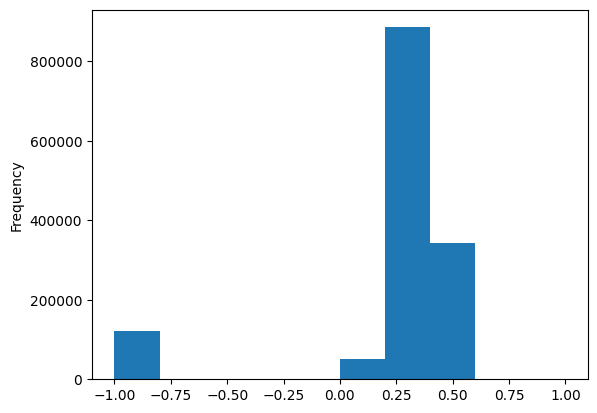

In [11]:
result.intensity.plot.hist()

In [323]:
featherFile = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs\SA_POC_wr_03112022.feather"
result.to_feather(featherFile)

In [14]:
gdf = gpd.GeoDataFrame(result[['gid','Land_Use','intensity']], geometry = gpd.points_from_xy(result.x, result.y), crs= 'EPSG:4326')

In [18]:
gdf.to_file("SA_pts_result.shp")

In [20]:
# convert to FeatureCollection using one line of code
fc = ee.FeatureCollection('projects/ee-geethensingh/assets/Hayley/SA_pts_result')

In [24]:
eeprint(fc.first().propertyNames())

In [30]:
# Convert regular spaced points to ee.Image
proj = ee.Projection('EPSG:4326')
grid = aoi.geometry().coveringGrid(proj, 1000)

def pointToGrid(ft):
    feat = ee.Feature(ft);
    first = fc.filterBounds(feat.geometry())
    return feat.set("intensity", first.get("intensity"));

outfile = grid.map(pointToGrid)\
.reduceToImage(**{'properties': ee.List(['intensity']), 'reducer': ee.Reducer.first()})

In [31]:
eeprint(outfile.reduceReion)
# https://code.earthengine.google.com/93771600a3347bc42a81efe357117992

In [33]:
Map = geemap.Map()
Map.addLayer(outfile)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [17]:
#Alternatively export image to assets first then export to drive/download via geedim
task = ee.batch.Export.image.toAsset(**{'image':outfile, 'description': 'SA_POC', 'assetId':'projects/ee-geethensingh/assets/SA_POC', 'region': aoi, 'scale': 1000, 'maxPixels': 1e13})
task.start()

EEException: Request payload size exceeds the limit: 10485760 bytes.

## Urban Cover

In [ ]:
# Urban cover (10m>250m>1km) 2019
area = ee.Image.pixelArea().divide(1e6).clip(aoi.geometry().buffer(5000))
urban_cover = ee.ImageCollection("projects/sat-io/open-datasets/WSF/WSF_2019")
projection = ee.Image(urban_cover.filterBounds(aoi).first()).projection()
urban_cover = urban_cover.filterBounds(aoi).mosaic().selfMask().setDefaultProjection(projection)
areaImage = area.updateMask(urban_cover).setDefaultProjection(projection)#.addBands(grid1km)

# Aggregate to 1km

# Projection at 250 m
projectionAt100m = projection.atScale(100)

urban_cover100m = areaImage.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt100m
  })

# Projection at 1 km
projectionAt1k = projection.atScale(1000)

urban_cover1k = urban_cover100m.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('areakm2_urban')

eeprint(urban_cover1k)
Map.addLayer(areaImage,{}, 'urban')

## Irrigated areas

In [ ]:
# Highly irrigated areas (9276km) 2019
area = ee.Image.pixelArea().divide(1e6).clip(aoi.geometry().buffer(5000))
irrigated = ee.Image("users/deepakna/global_irrigation_maps/2015").selfMask().rename('irrigation')
projection = irrigated.projection()
irrigatedMed = area.updateMask(irrigated.eq(1)).setDefaultProjection(projection)
irrigatedHigh = area.updateMask(irrigated.eq(2)).setDefaultProjection(projection)
# Aggregate to 1km
# Projection at 1 km
projectionAt1k = projection.atScale(1000)

irrigationMed1k = irrigatedMed.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('areakm2_irrig_med')

irrigationHigh1k = irrigatedHigh.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('areakm2_irrig_high')
eeprint(irrigationMed1k)
Map.addLayer(irrigationMed1k,{}, 'irrigated Medium')

## Crop Cover

In [ ]:
#Crop cover (30 m)
area = ee.Image.pixelArea().divide(1e6).clip(aoi.geometry().buffer(5000))
crop_cover = ee.ImageCollection("users/potapovpeter/Global_cropland_2019") 
projection = ee.Image(crop_cover.filterBounds(aoi).first()).projection()

crop_cover = crop_cover.filterBounds(aoi).mosaic().selfMask()
eeprint(crop_cover.projection().nominalScale())
cropAreaImage = area.updateMask(crop_cover).setDefaultProjection(projection)

# Projection at 300 m
projectionAt300m = projection.atScale(300)

cropCover300m = areaImage.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt300m
  })

projectionAt1k = projection.atScale(1000)
cropCover1k = cropCover300m.reduceResolution(**{\
       'reducer':ee.Reducer.sum().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1k}).rename('areakm2_cropCover')

eeprint(cropCover1k)
Map.addLayer(cropCover1k,{},'Crop cover')

## Protected areas

In [ ]:
#protected area
prot_areas = ee.FeatureCollection("projects/ee-geethensingh/assets/WDPA_Africa_strict").filterBounds(aoi)
# eeprint(prot_areas)

area = ee.Image.pixelArea().divide(1e6).clip(aoi)
projection = area.projection()
projectionAt1km = projection.atScale(1000)

protectedAreaImage = area.clipToCollection(prot_areas)

# projectionAt300m = projection.atScale(300)
# protArea300m = protectedAreaImage.reduceResolution(**{\
#        'reducer':ee.Reducer.sum().unweighted(),\
#        'maxPixels':1024}).reproject(**{\
#         'crs':projectionAt300m}).rename('areakm2_protectedArea')


protArea1km = protectedAreaImage.reduceResolution(**{\
       'reducer':ee.Reducer.sum().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1k}).rename('areakm2_protectedArea')

eeprint(protArea1km)
Map.addLayer(protArea1km,{},'Protected Areas')

## Soil Nutrient status

In [ ]:
Soil_Lownutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'Low')).map(lambda ft: ft.set('Nut_status_id', 0))
eeprint(Soil_Lownutrient.size())

Soil_Mednutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'Medium')).map(lambda ft: ft.set('Nut_status_id', 1))
eeprint(Soil_Mednutrient.size())

Soil_Highnutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map")\
.filter(ee.Filter.eq('Nut_status', 'High')).map(lambda ft: ft.set('Nut_status_id', 2))
eeprint(Soil_Highnutrient.size())

Soil_nutrient = Soil_Lownutrient.merge(Soil_Mednutrient).merge(Soil_Highnutrient)
eeprint(Soil_nutrient.size())

Soil_nutrient = ee.FeatureCollection("projects/ee-geethensingh/assets/Bell_1982_nutrient_map").filterBounds(aoi)\
.map(lambda x: x.set("id",x.get("Nut_statusid")))\
.reduceToImage(**{'properties': ee.List(["id"]), 'reducer': ee.Reducer.first()}).unmask().rename('soilStatus')
# eeprint(Soil_nutrient)

area = ee.Image.pixelArea().divide(1e6).clip(aoi.geometry().buffer(5000))
soilLowNutrientAreaImage = area.updateMask(Soil_nutrient.eq(0).selfMask()).setDefaultProjection(projectionAt1k)
soilMedNutrientAreaImage = area.updateMask(Soil_nutrient.eq(1).selfMask()).setDefaultProjection(projectionAt1k)
soilHighNutrientAreaImage = area.updateMask(Soil_nutrient.eq(2).selfMask()).setDefaultProjection(projectionAt1k)

# soilLowArea300m = soilLowNutrientAreaImage.reduceResolution(**{\
#        'reducer':ee.Reducer.sum().unweighted(),\
#        'maxPixels':1024}).reproject(**{\
#         'crs':projectionAt300m}).rename('areakm2_soilLow')
# soilMedArea300m = soilMedNutrientAreaImage.reduceResolution(**{\
#        'reducer':ee.Reducer.sum().unweighted(),\
#        'maxPixels':1024}).reproject(**{\
#         'crs':projectionAt300m}).rename('areakm2_soilMed')
# soilHighArea300m = soilHighNutrientAreaImage.reduceResolution(**{\
#        'reducer':ee.Reducer.sum().unweighted(),\
#        'maxPixels':1024}).reproject(**{\
#         'crs':projectionAt300m}).rename('areakm2_soilHigh')

soilLowArea1km = soilLowNutrientAreaImage.reduceResolution(**{\
       'reducer':ee.Reducer.sum().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1k}).rename('areakm2_soilLow')
soilMedArea1km = soilMedNutrientAreaImage.reduceResolution(**{\
       'reducer':ee.Reducer.sum().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1k}).rename('areakm2_soilMed')
soilHighArea1km = soilHighNutrientAreaImage.reduceResolution(**{\
       'reducer':ee.Reducer.sum().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1k}).rename('areakm2_soilHigh')

# eeprint(soilLowArea1km)
# Map.addLayer(soilLowArea1km,{},'soil Low')

## Sand Content

In [ ]:
sand_content = ee.Image("projects/sat-io/open-datasets/iSDAsoil_Africa_30m/sand_content").select('b1')
eeprint(sand_content.bandNames())

projection = sand_content.projection()
# Aggregate to 1km
# Projection at 300 m
projectionAt300m = projection.atScale(300)

sand_content300m = sand_content.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt300m
  })

# Projection at 1 km
projectionAt1k = projection.atScale(1000)

sandContent1k = sand_content300m.clip(aoi).reduceResolution(**{\
    'reducer': ee.Reducer.mean().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('mean_sandContent')
# eeprint(sandContent1k)
# Map.addLayer(sandContent1k,{}, 'sand Content')

# Precipitation

In [ ]:
years = list(range(1991,2021))

precipitation = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
projection = ee.Image(precipitation.filterBounds(aoi).first()).projection()

precipitation = precipitation.filterBounds(aoi)  
precipitation = ee.Image(ee.ImageCollection(ee.List(years).map(lambda year: precipitation\
.filterDate(ee.Number(year).format(), ee.Number(year).add(1).format()).sum())).mean().rename('precipitation')).setDefaultProjection(projection)    
eeprint(precipitation)     

# Aggregate to 1km
# Projection at 1 km
projectionAt1k = projection.atScale(1000)

precip1k = precipitation.reduceResolution(**{\
    'reducer': ee.Reducer.mean().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('mean_precip')
# eeprint(precip1k)
# Map.addLayer(precip1k,{}, 'precipitation')

## Population Density 1

In [ ]:
# https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_UNWPP-Adjusted_Population_Density#description
pop_density = ee.ImageCollection("CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density")\
.select('unwpp-adjusted_population_density')
projection = ee.Image(pop_density.filterBounds(aoi).first()).projection()

pop_density = pop_density.filterBounds(aoi).mosaic().setDefaultProjection(projection)    
eeprint(pop_density)     

# Aggregate to 1km
# Projection at 1 km
projectionAt1k = projection.atScale(1000)

popDensity1k1 = pop_density.reduceResolution(**{\
    'reducer': ee.Reducer.mean().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('mean_popDensity1')
# eeprint(popDensity1k1)
# Map.addLayer(popDensity1k1,{}, 'mean_popDensity1')

## Population Density 2

In [ ]:
HRSL = ee.ImageCollection("projects/sat-io/open-datasets/hrsl/hrslpop")

projection = ee.Image(HRSL.filterBounds(aoi).first()).projection()
eeprint(projection)

HRSL = HRSL.filterBounds(aoi).mosaic().setDefaultProjection(projection)    
eeprint(HRSL)     

# Aggregate to 1km
# Projection at 300 m
projectionAt300m = projection.atScale(300)

HRSL300m = HRSL.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt300m
  })

# Projection at 1 km
projectionAt1k = projection.atScale(1000)

popDensity1k2 = HRSL300m.reduceResolution(**{\
    'reducer': ee.Reducer.mean().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('mean_popDensity2')
# eeprint(popDensity1k2)
# Map.addLayer(popDensity1k2,{}, 'mean_popDensity2')

## Grazing Density

In [ ]:
cattle_density = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Ct_2010_Da')
projection = cattle_density.projection()
# Aggregate to 1km
# Projection at 1 km
projectionAt1k = projection.atScale(1000)

cattleDensity1k = cattle_density.clip(aoi).reduceResolution(**{\
    'reducer': ee.Reducer.mean().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('mean_cattleDensity')
eeprint(cattleDensity1k)
Map.addLayer(cattleDensity1k,{}, 'cattleDensity')

sheep_density = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Sh_2010_Da')
projection = sheep_density.projection()
# Aggregate to 1km
# Projection at 1 km
projectionAt1k = projection.atScale(1000)

sheepDensity1k = sheep_density.clip(aoi).reduceResolution(**{\
    'reducer': ee.Reducer.mean().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('mean_sheepDensity')
eeprint(sheepDensity1k)
Map.addLayer(sheepDensity1k,{}, 'sheepDensity')


goat_density = ee.Image('projects/ee-geethensingh/assets/GrazingDensity/5_Gt_2010_Da')
projection = goat_density.projection()
# Aggregate to 1km
# Projection at 1 km
projectionAt1k = projection.atScale(1000)

goatDensity1k = goat_density.clip(aoi).reduceResolution(**{\
    'reducer': ee.Reducer.mean().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt1k
  }).rename('mean_goatDensity')
eeprint(goatDensity1k)
# Map.addLayer(goatDensity1k,{}, 'goatDensity')

## Nitrogen input

In [ ]:
Nitrogen_input = ee.FeatureCollection("projects/ee-geethensingh/assets/Nfur_15arcmins")

urban_cover = ee.ImageCollection("projects/sat-io/open-datasets/WSF/WSF_2019")
projection = ee.Image(urban_cover.filterBounds(aoi).first()).projection()
projectionAt1k = projection.atScale(1000)

Nitrogen_input = Nitrogen_input.filterBounds(aoi)\
.map(lambda x: x.set("Nfer_kgha_",ee.Number(x.get("Nfer_kgha_")).toFloat()))\
.reduceToImage(**{'properties': ee.List(["Nfer_kgha_"]), 'reducer': ee.Reducer.first()}).unmask().rename('nInput')

nitrogenInput = Nitrogen_input.clip(aoi).selfMask().setDefaultProjection(projection)

nitrogenInput1k = nitrogenInput.reduceResolution(**{\
       'reducer':ee.Reducer.mean().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1k}).rename('mean_Nitrogen_input')

eeprint(nitrogenInput1k)
# Map.addLayer(nitrogenInput1k,{},'Nitrogen input')

## Field Size

In [ ]:
field_size = ee.FeatureCollection("projects/ee-geethensingh/assets/dominant_field_sizes").filterBounds(aoi)\
.map(lambda x: x.set('field_size',ee.Number(x.get('field_size')).toFloat()))\
.reduceToImage(**{'properties': ee.List(['field_size']), 'reducer': ee.Reducer.first()}).unmask().rename('fieldSize')

urban_cover = ee.ImageCollection("projects/sat-io/open-datasets/WSF/WSF_2019")
projection = ee.Image(urban_cover.filterBounds(aoi).first()).projection()
projectionAt1k = projection.atScale(1000)

fieldSize = field_size.clip(aoi).selfMask().setDefaultProjection(projection)

fieldSize1k = fieldSize.reduceResolution(**{\
       'reducer':ee.Reducer.mean().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1km}).rename('mean_fieldSize')

eeprint(fieldSize1k)
# Map.addLayer(fieldSize1k,{},'field size')

## Plantations and tree crop

In [ ]:
result = ee.ImageCollection("users/liuzhujun/SDPT_NEW").mosaic()
plantag = ee.Image("users/duzhenrong/SDPT/sdpt_plantag")
china_plantyear = ee.ImageCollection("users/liuzhujun/SDPT_China").mosaic().rename('plantyear')
DescalesOP = ee.ImageCollection("users/liuzhujun/Descales").mosaic()
op = DescalesOP.updateMask(DescalesOP.gt(1980)).rename('plantyear')
sdpt_name = ee.Image("users/duzhenrong/SDPT/sdpt_name")

china_plantyear=china_plantyear.updateMask(china_plantyear.gt(1980))
result=result.rename('plantyear').updateMask((sdpt_name.lt(120).And(sdpt_name.gt(0))).Or(sdpt_name.gt(129))).toInt32()

plantationForest=ee.ImageCollection([result.updateMask(plantag.eq(1)),china_plantyear]).mosaic()
eeprint(plantationForest)
treeCrop=result.updateMask(plantag.eq(2))
treeCrop =ee.ImageCollection([treeCrop,op]).mosaic()
eeprint(treeCrop)

urban_cover = ee.ImageCollection("projects/sat-io/open-datasets/WSF/WSF_2019")
projection = ee.Image(urban_cover.filterBounds(aoi).first()).projection()
plantationForestAreaImage = area.updateMask(plantationForest).setDefaultProjection(projection)

# Aggregate to 1km
# Projection at 300 m
projectionAt300m = projection.atScale(300)

plantationForest300m = plantationForestAreaImage.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt300m
  })

# Projection at 1 km
projectionAt1k = projection.atScale(1000)
plantationForest1k = plantationForest300m.reduceResolution(**{\
       'reducer':ee.Reducer.sum().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1k}).rename('areakm2_plantationForest')

eeprint(plantationForest1k)
# Map.addLayer(plantationForest1k,{},'plantation forest')

urban_cover = ee.ImageCollection("projects/sat-io/open-datasets/WSF/WSF_2019")
projection = ee.Image(urban_cover.filterBounds(aoi).first()).projection()
treeCropAreaImage = area.updateMask(treeCrop).setDefaultProjection(projection)

# Aggregate to 1km
# Projection at 300 m
projectionAt300m = projection.atScale(300)

treeCropArea300m = treeCropAreaImage.reduceResolution(**{\
    'reducer': ee.Reducer.sum().unweighted(),\
    'maxPixels': 1024}).reproject(**{\
    'crs': projectionAt300m
  })
# Projection at 1 km
projectionAt1k = projection.atScale(1000)
treeCrop1k = treeCropArea300m.reduceResolution(**{\
       'reducer':ee.Reducer.sum().unweighted(),\
       'maxPixels':1024}).reproject(**{\
        'crs':projectionAt1k}).rename('areakm2_treeCrop')

eeprint(treeCrop1k)
# Map.addLayer(treeCrop1k,{},'plantation forest')

## Fragmentation

## Compile covaraites

In [ ]:
covariates = grid1km.rename('grid_1km').addBands([grid8km.rename('grid_8km'),\
                            urban_cover1k, irrigationMed1k, irrigationHigh1k,\
                            cropCover1k, protArea1km, soilLowArea1km, soilMedArea1km,\
                        soilHighArea1km, plantationForest1k, treeCrop1k,\
                        sandContent1k, precip1k,popDensity1k1, popDensity1k2,\
                        cattleDensity1k,sheepDensity1k, goatDensity1k, nitrogenInput1k,\
                        fieldSize1k])

layers = covariates.bandNames().getInfo()
for layer in tqdm(layers):
    layer = covariates.select(layer)
    name = layer.bandNames().getInfo()[0]
    desc = name
    aid = 'projects/ee-geethensingh/assets/Hayley/SA_'+ str(name)
    task = ee.batch.Export.image.toAsset(layer.clip(aoi), description = desc, assetId = aid, region =  aoi.geometry().buffer(8000), scale = 1000, maxPixels = 1e13)
    task.start()

In [ ]:
task.status()

## Extract data

In [ ]:
eeprint(sumCovariates.bandNames())
eeprint(meanCovariates.bandNames())

In [ ]:
i = 911806#id1km[2]
print('1km cell id:', i)
scell = grid1km.addBands(sumCovariates).updateMask(grid1km.eq(i)).selfMask()
gridCell = scell.reduceToVectors(**{'geometry': aoi, 'scale': 1000, 'geometryType': 'polygon',\
                                'eightConnected': False, 'labelProperty': 'id', 'reducer': ee.Reducer.sum()})

eeprint(gridCell)

eeprint(sumCovariates.reduceRegion(ee.Reducer.sum(), scale = 1000, geometry = gridCell))
# eeprint(meanCovariates.reduceRegion(ee.Reducer.mean(), scale = 1000, geometry = gridCell))

In [ ]:
%%timeit
i = 911806#id1km[2]
print('1km cell id:', i)
scell = grid1km.updateMask(grid1km.eq(i).selfMask())
gridCell = grid1km.addBands(sumCovariates).updateMask(scell)\
.reduceConnectedComponents(reducer= ee.Reducer.sum(), maxSize =256)

eeprint(gridCell)

# eeprint(sumCovariates.reduceRegion(ee.Reducer.sum(), scale = 1000, geometry = gridCell))
# eeprint(meanCovariates.reduceRegion(ee.Reducer.mean(), scale = 1000, geometry = gridCell))

In [ ]:
Map = geemap.Map()
Map.centerObject(ee.Geometry.Point([27.858, -25.742]), 13)
Map.addLayer(gridCell)
Map

In [ ]:
dd = r"C:\Users\coach\myfiles\miscellenous\hayley\outputs"
sumImageList = [urbanAreaImage, cropAreaImage, plantationAreaImage, treeCropAreaImage,\
                protectedAreaImage, irrigatedMed, irrigatedHigh,\
                soilLowNutrientAreaImage, soilMedNutrientAreaImage, soilHighNutrientAreaImage]

meanImageList = [grid1km,grid8km.rename('id8km'),sandContent, precipitation, popDensity, cattleDensity,\
                                       sheepDensity, goatDensity, nitrogenInput, fieldSize]
    
for image in sumImageList:
    iName = image.bandNames().getInfo()[0]
    print(iName)
    scale = image.projection().nominalScale()
    extractor(image, aoi.geometry(), scale = 1000, dd = dd, target = grid1km, crs = 'EPSG:4326', num_threads = 25)\
    .extractRasterGrid(reduce = True, reducer = ee.Reducer.sum(), gridSize = 100000, batchSize = 100, filename = f'{iName}_1km.csv')

In [ ]:
bands = sumCovariates.bandNames().getInfo()[1:]
for cid in id1km[1:2]:
    print(cid)
    for band in bands:
        sumCell = sumCovariates.select([str(band)]).updateMask(grid1km.eq(cid).selfMask())\
        .reduceRegion(ee.Reducer.sum(), scale=1000, geometry= aoi, maxPixels= 1e13)
        eeprint(sumCell)

In [ ]:
bands = sumCovariates.bandNames().getInfo()[1:]
for cid in id8km[10:11]:
    print(cid)
    for band in bands:
        sumCell = sumCovariates.select([str(band), 'id' ]).updateMask(grid8km.eq(cid).selfMask())\
        .reduceRegion(ee.Reducer.sum().group(groupField=1, groupName='id1km'), scale=1000, geometry= aoi, maxPixels= 1e13)
        eeprint(sumCell)

## Decision tree

In [ ]:
covariates = grid1km.rename('grid_1km').addBands([grid8km.rename('grid_8km'),\
                            urban_cover1k, irrigationMed1k, irrigationHigh1k,\
                            cropCover1k, protArea1km, soilLowArea1km, soilMedArea1km,\
                        soilHighArea1km, plantationForest1k, treeCrop1k,\
                        sandContent1k, precip1k,popDensity1k1, popDensity1k2,\
                        cattleDensity1k,sheepDensity1k, goatDensity1k, nitrogenInput1k,\
                        fieldSize1k])
eeprint(covariates.bandNames())

In [ ]:
Urban = ee.Image.constant(1).updateMask(urban_cover1k.gt(0.20)\
                                        .And(popDensity1k1.gt(15000))).toInt()
# eeprint(Urban)

Settlements_nonAgric = ee.Image.constant(2).updateMask(popDensity1k1.gt(100)\
                        .And(cropCover1k.lt(0.05)\
                        .Or(treeCrop.lt(0.05)))).toInt()
# eeprint(Settlements_nonAgric)
                                                        
Agric_settlements = ee.Image.constant(3).updateMask(popDensity1k1.gt(100)\
                    .And(cropCover1k).gte(0.05).Or(cropCover1k.divide(1).lte(0.20))\
                    .And(treeCrop.gte(0.05)).Or(treeCrop.divide(1).lte(0.20))).toInt()
# eeprint(Agric_settlements)
                                                          
Timber_plantations = ee.Image.constant(4).updateMask(plantationForest1k.gt(0.20)).toInt()
# eeprint(Timber_plantations)
                                                     
treeCrop =  ee.Image.constant(5).updateMask(treeCrop1k.gt(0.20)).toInt()
# eeprint(treeCrop)
                                                             
Agric =  ee.Image.constant(6).updateMask(cropCover1k.gt(0.20)).toInt()
# eeprint(Agric)
                                                             
protArea = protArea1km.gt(0.5).toInt()
# eeprint(protArea)
                                                             
landUse = ee.ImageCollection.fromImages([Urban,Settlements_nonAgric, Agric_settlements, Timber_plantations,\
                          treeCrop, Agric, protArea, ee.Image.constant(7)]).min().toInt()
eeprint(landUse)

In [ ]:
task = ee.batch.Export.image.toAsset(Urban.toInt(), description = 'SA_LU', assetId = 'users/geethensingh/SA_Urban_1km', region =  aoi.geometry(), scale = 1000, maxPixels = 1e13)
task.start()

In [ ]:
task.status()